## Impoting relevant libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from fastai.vision.all import *
import PIL
import shutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
input_images= os.listdir('/kaggle/input/mit-5k-basic/fivek_512px/input')
output_images= os.listdir('/kaggle/input/mit-5k-basic/fivek_512px/expertC_gt')
input_path = '/kaggle/input/mit-5k-basic/fivek_512px/input/'
output_path = '/kaggle/input/mit-5k-basic/fivek_512px/expertC_gt/'

In [3]:
if os.path.exists('Dataset/train/Input') is False:
    os.makedirs('Dataset/train/Input')
if os.path.exists('Dataset/test/Input') is False:
    os.makedirs('Dataset/test/Input')

In [4]:
if os.path.exists('Dataset/train/Output') is False :
    os.makedirs('Dataset/train/Output')
if os.path.exists('Dataset/test/Output') is False :
    os.makedirs('Dataset/test/Output')

In [5]:
save_path_input = 'Dataset/train/Input/'
save_path_input_test = 'Dataset/test/Input'
cnt = 0
for image in input_images:
    if cnt < 4500:
        img = Image.open(input_path+image)
        new_img = img.resize((256,256))
        new_img.save(save_path_input+image)
    else:
        img = Image.open(input_path+image)
        new_img = img.resize((256,256))
        new_img.save(save_path_input_test+image)
    cnt+=1

In [6]:
save_path_output_test = 'Dataset/test/Output'
save_path_output = 'Dataset/train/Output/'
cnt = 0
for image in output_images:
    if cnt < 4500:
        img = Image.open(output_path+image)
        new_img = img.resize((256,256))
        new_img.save(save_path_output+image)
    else:
        img = Image.open(output_path+image)
        new_img = img.resize((256,256))
        new_img.save(save_path_output_test+image)
    cnt+=1

In [7]:
count1 = os.listdir(save_path_input)
count2 = os.listdir(save_path_output)

print(len(count1),len(count2))

4500 4500


In [8]:
path = "/kaggle/working/Dataset/train/Input"
path_out = "/kaggle/working/Dataset/train/Output"
num_images = 4500

input_images= sorted(glob.glob(path + "/*.jpg"))[:num_images]
output_images = sorted(glob.glob(path_out + "/*.jpg"))[:num_images]

images = np.zeros(shape=(len(input_images), 256, 256, 3))
masks = np.zeros(shape=(len(output_images), 256, 256, 3))

for idx, path in enumerate(input_images):
    combined_image = tf.cast(img_to_array(load_img(path)), tf.float32)
    images[idx] = (combined_image)/255
    
for idx, path in enumerate(output_images):
    combined_image = tf.cast(img_to_array(load_img(path)), tf.float32)
    masks[idx] = (combined_image)/255

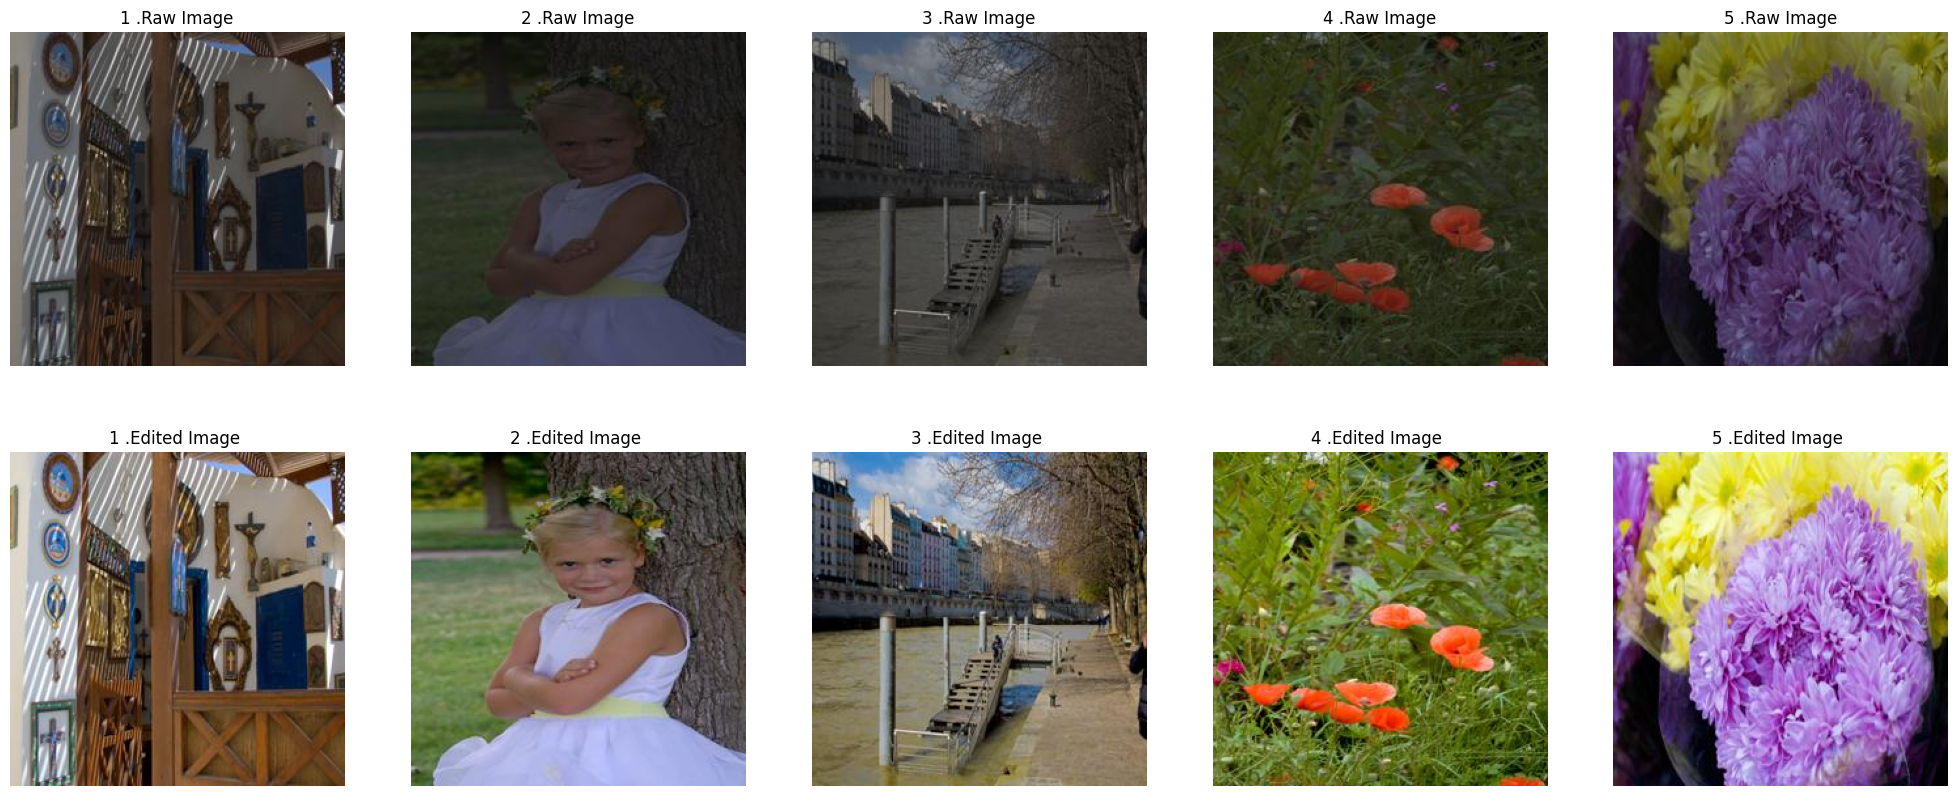

In [9]:
plt.figure(figsize=(25,10))
for i in range(1,6):
    idx = np.random.randint(1,1000)
    image, mask = images[idx], masks[idx]
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title(str(i) + " .Raw Image")
    plt.axis("off")
    
    plt.subplot(2,5,i + 5)
    plt.imshow(mask)
    plt.title(str(i) + " .Edited Image ")
    plt.axis("off")
plt.show()

In [10]:
def downscale(num_filters):
    block = Sequential()
    block.add(Conv2D(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    return block

def upscale(num_filters):
    block = Sequential()
    block.add(Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    block.add(ReLU())
    return block

def Generator():
    inputs = Input(shape=(256,256,3), name="InputLayer")

    encoder = [
        downscale(64),
        downscale(128),
        downscale(256),
        downscale(512),
        downscale(512),
        downscale(512),
        downscale(512),
    ]
    
    latent_space = downscale(512)

    decoder = [
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(256),
        upscale(128),
        upscale(64),
    ]
    
    x = inputs 
    skips = []
    for layer in encoder:
        x = layer(x)
        skips.append(x)
    
    x = latent_space(x)

    skips = reversed(skips)
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = concatenate([x, skip])
    
    initializer = RandomNormal(stddev=0.02, seed=42)
    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, kernel_initializer = initializer, activation = 'tanh', padding = 'same')

    outputs = outputs(x)

    generator = Model(inputs = inputs, outputs = outputs, name="Generator")
    return generator

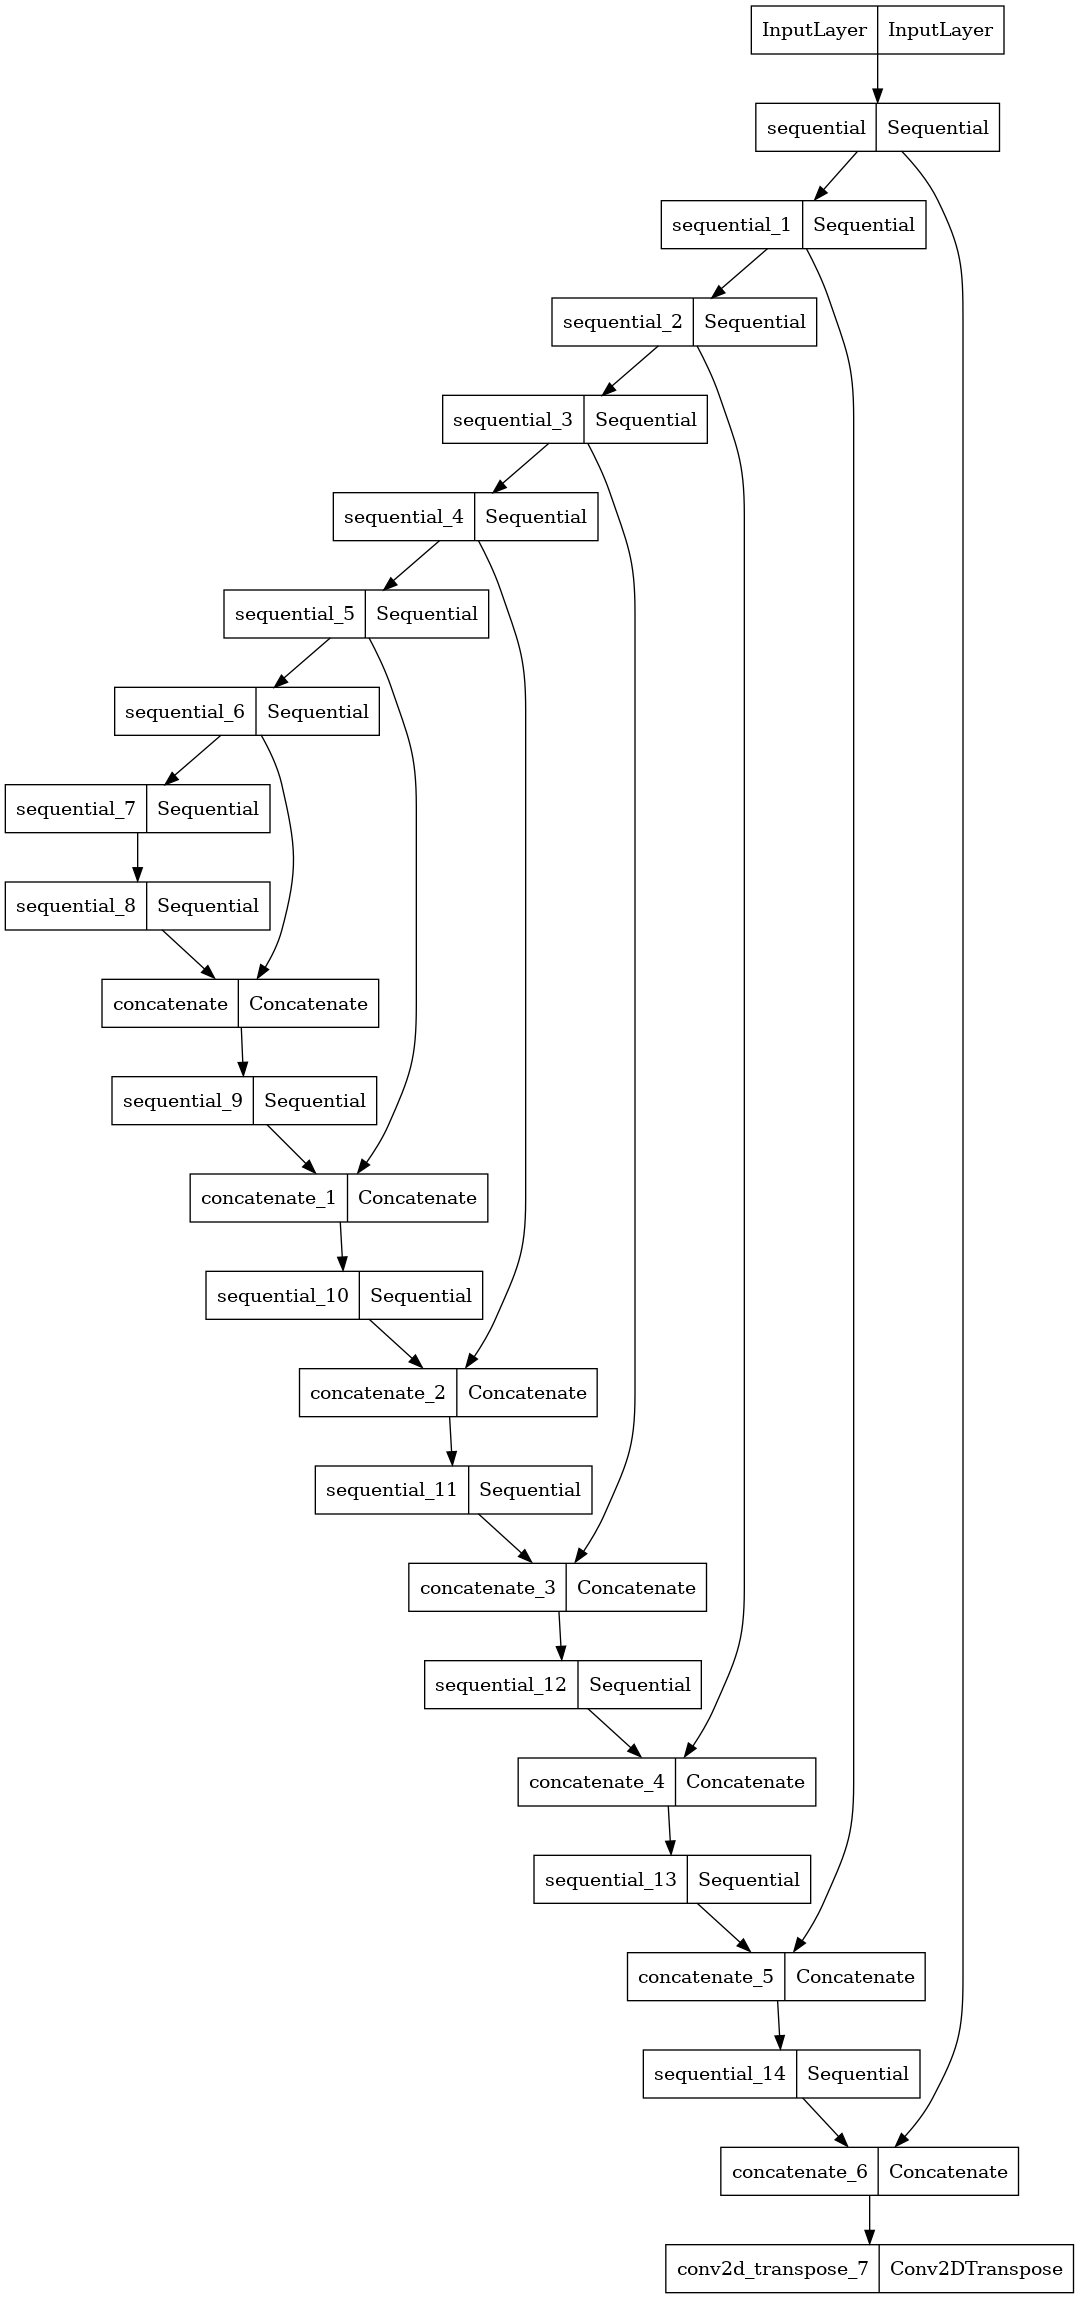

In [11]:
generator = Generator()
plot_model(generator)

In [12]:
def Discriminator():
    image = Input(shape = (256,256,3), name = "ImageInput")
    target = Input(shape = (256,256,3), name = "TargetInput")
    x = concatenate([image, target])

    x = downscale(64)(x)
    x = downscale(128)(x)
    x = downscale(512)(x)

    initializer = RandomNormal(stddev = 0.02, seed=42)
        
    x = Conv2D(512, kernel_size = 4, strides = 1, kernel_initializer = initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, kernel_size = 4, kernel_initializer = initializer)(x)

    discriminator = Model(inputs = [image, target], outputs = x, name = "Discriminator")

    return discriminator

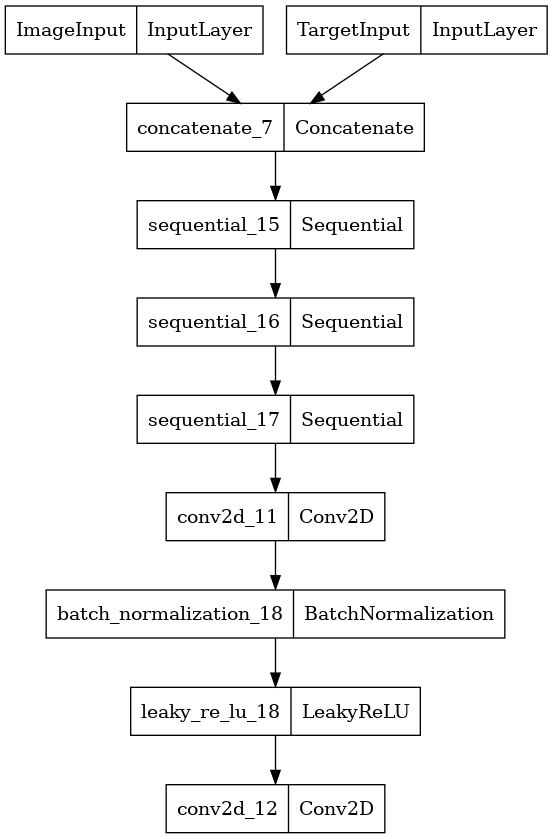

In [13]:
discriminator = Discriminator()
plot_model(discriminator)

In [14]:
adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def generator_loss(discriminator_generated, generated_output, target_image):
    gan_loss = adversarial_loss(tf.ones_like(discriminator_generated), discriminator_generated)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_output))
    total_loss = (100 * l1_loss) + gan_loss
    return total_loss, gan_loss, l1_loss

def discriminator_loss(discriminator_real_output, discriminator_generated_output):
    real_loss = adversarial_loss(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = adversarial_loss(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

def train_step(inputs, target):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_output = generator(inputs, training=True)
        
        discriminator_real_output = discriminator([inputs, target], training=True)
        discriminator_generated_output = discriminator([inputs, generated_output], training=True)
        
        generator_total_loss, generator_gan_loss, generator_l1_loss = generator_loss(discriminator_generated_output, generated_output, target)
        
        discriminator_Loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)
        
    generator_gradients = generator_tape.gradient(generator_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    discriminator_gradients = discriminator_tape.gradient(discriminator_Loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [15]:
def fit(data, epochs):
  for epoch in range(epochs):
    start = time.time()
    print("Current epoch: ", epoch+1)
    for image, mask in data:
      train_step(image, mask)
    print(f"Time taken to complete the epoch {epoch + 1} is {(time.time() - start):.2f} seconds \n")

In [16]:
raw_image, edit_image = tf.cast(images, tf.float32), tf.cast(masks, tf.float32)
dataset = (raw_image,edit_image)
data = tf.data.Dataset.from_tensor_slices(dataset).batch(32, drop_remainder=True)

In [17]:
fit(data, 100)

Current epoch:  1
Time taken to complete the epoch 1 is 128.64 seconds 

Current epoch:  2
Time taken to complete the epoch 2 is 104.65 seconds 

Current epoch:  3
Time taken to complete the epoch 3 is 104.67 seconds 

Current epoch:  4
Time taken to complete the epoch 4 is 104.96 seconds 

Current epoch:  5
Time taken to complete the epoch 5 is 104.82 seconds 

Current epoch:  6
Time taken to complete the epoch 6 is 104.66 seconds 

Current epoch:  7
Time taken to complete the epoch 7 is 104.63 seconds 

Current epoch:  8
Time taken to complete the epoch 8 is 104.63 seconds 

Current epoch:  9
Time taken to complete the epoch 9 is 104.67 seconds 

Current epoch:  10
Time taken to complete the epoch 10 is 104.67 seconds 

Current epoch:  11
Time taken to complete the epoch 11 is 104.61 seconds 

Current epoch:  12
Time taken to complete the epoch 12 is 104.34 seconds 

Current epoch:  13
Time taken to complete the epoch 13 is 103.99 seconds 

Current epoch:  14
Time taken to complete t

In [18]:
def show_predictions(num_samples):
    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images[idx], masks[idx]
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("RAW Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("Edit Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Predicted Image " + str(i + 1))
        plt.axis('off')
        
        plt.show()

1/1 [==============================] - 1s 704ms/step


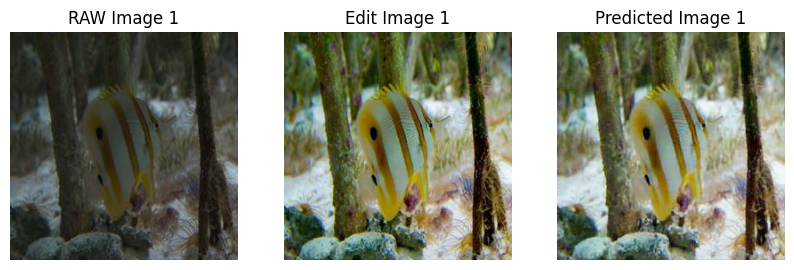

1/1 [==============================] - 0s 22ms/step


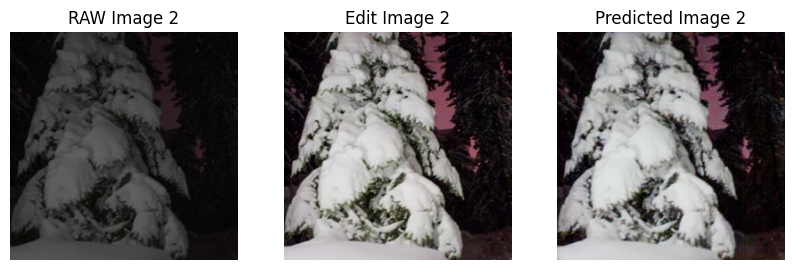

1/1 [==============================] - 0s 30ms/step


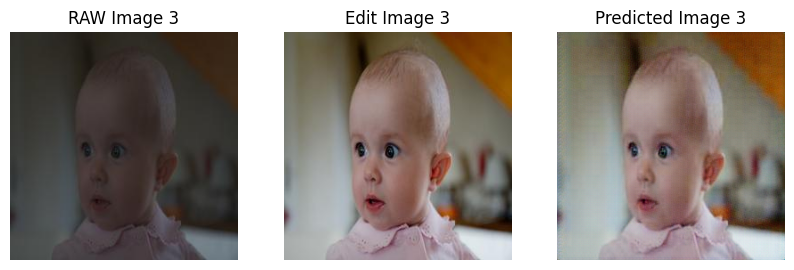

1/1 [==============================] - 0s 22ms/step


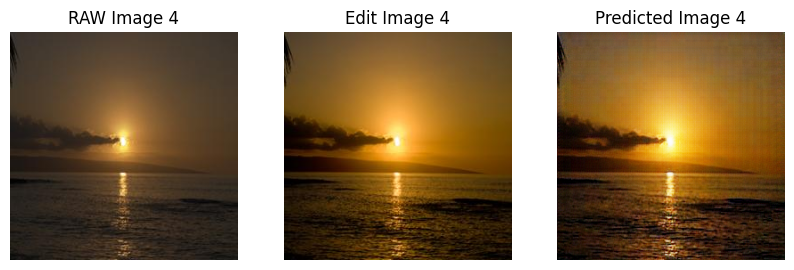

1/1 [==============================] - 0s 21ms/step


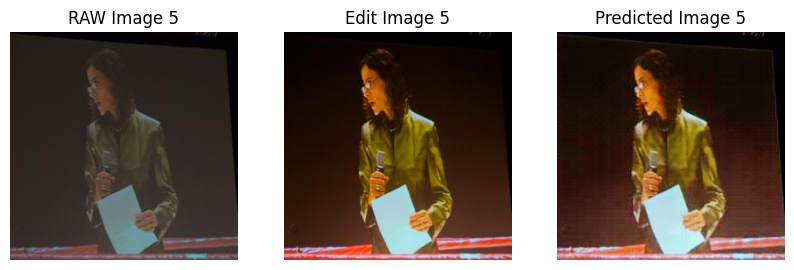

In [19]:
show_predictions(5)

In [20]:
generator.save("GAN_Raw_image_2_edit.h5")